# Portfolio Management for retail Investors

The purpose of this project is to create a model, using Machine Learning algorithms, that predicts future annual returns and future annual volatility for a given number of stocks. After doing that, we will create an optimal portfolio depending on the risk aversion of the investor. The project is divided into three parts. The first part proves some general assumptions about the stock market, such as the fact that stock market returns follow a normal distribution and that an Exponential Moving Average can be used as a proxy to identify market trends. The second part is devoted in creating the data frames of the stocks that we will analyze and constructing the model that predicts future annual returns and future annual volatility. Finally, the last part of the project is to calculate the optimal portfolio depending on the risk aversion of the investor.

## Outline

- [Portfolio Management for retail Investors](#Portfolio-Management-for-retail-Investors)  
  - [General Observations about asset returns](#General-Observations-about-asset-returns)  
  - [Model](#Model)  
  - [Optimal Portfolio](#Optimal-Portfolio)  

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.patches as patches
import seaborn as sns
import yfinance as yf
from datetime import datetime
from pandas_datareader import data as pdr
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff

## General Observations about asset returns

We start by selecting a basket of stocks and bond ETFs; I mainly focus on technology companies since they yield higher returns compared to other sectors. Yet, since this model can be easily customized to anyone's need, so you can pick your own basket. I also choose four of the largest bond ETFs. They will serve as a mechanism to achieve greater diversification of our optimal portfolio. SPY is chosen as a benchmark for stocks and AGG (largest bond ETF) as a benchmark for bond ETFs.

In [2]:
stocks = ["AMZN" , "AAPL" , "GOOGL" , "FB" , "WMT", "MSFT" , "SPY"]
bonds = ["BND" , "VCIT" , "VCSH" , "AGG"]

# Dataframe for stocks
df_stocks = pdr.get_data_yahoo(stocks,
                          start='2013-01-01',
                          end=datetime.today().strftime('%Y-%m-%d'),
                          )["Adj Close"].round(3)

# Dataframe for bond ETFs
df_bonds = pdr.get_data_yahoo(bonds,
                          start='2013-01-01',
                          end=datetime.today().strftime('%Y-%m-%d'),
                          )["Adj Close"].round(3)

#20 day Exponential Moving Average
ema_20_stocks = df_stocks.ewm(span=20, adjust=False).mean()

ema_20_bonds = df_bonds.ewm(span=20, adjust=False).mean()

#100 day Exponential Moving Average

ema_100_stocks = df_stocks.ewm(span=100, adjust=False).mean()

ema_100_bonds = df_bonds.ewm(span=100, adjust=False).mean()


# Annual stock returns
annualized_returns_stocks = df_stocks.pct_change(periods = 253)


# Annual bond returns
annualized_returns_bonds = df_bonds.pct_change(periods = 253)

# Annual bond volatility 
annualized_volatility_bonds = pd.DataFrame(df_bonds.pct_change(periods = 253).iloc[i-253:i].std() 
                                          for i in range(len(df_bonds.index)))

#We use 253 because on average there are 253 trading days in a year

In [3]:
df_bonds.tail()

Symbols        BND    VCIT    VCSH     AGG
Date                                      
2020-12-17  87.839  96.612  83.039  117.85
2020-12-18  87.809  96.552  83.039  117.79
2020-12-21  87.819  96.483  82.979  117.79
2020-12-22  87.959  96.652  83.039  117.96
2020-12-23  87.860  96.730  83.080  117.88

In [4]:
df_stocks.tail()

Symbols        AMZN    AAPL    GOOGL      FB     WMT    MSFT     SPY
Date                                                                
2020-12-17  3236.08  128.70  1740.51  274.48  146.10  219.42  370.66
2020-12-18  3201.65  126.66  1726.22  276.40  145.95  218.59  369.18
2020-12-21  3206.18  128.23  1734.56  272.79  145.97  222.59  367.86
2020-12-22  3206.52  131.88  1720.22  267.09  144.20  223.94  367.24
2020-12-23  3185.27  130.96  1728.23  268.11  143.22  221.02  367.57

Constructing a portfolio management model that gives reliable predictions requires to firstly lay out some key assumptions about financial markets; namely that Stock market returns tend to follow a normal distribution and also that the movement of a stock price is not entirely random. Momentum plays a key role in identifying a trend and approximating future performance. The following figures prove the two assumptions that we just introduced. 

In [5]:
group_labels_stocks = ['Weekly Returns AMZN', 'Weekly Returns AAPL' , 'Weekly Returns GOOGL', 'Weekly Returns FB',
                'Weekly Returns TSLA', 'Weekly Returns WMT','Weekly Returns MSFT', 'Weekly Returns SPY' ]

group_labels_bonds = ['Monthly Returns BND', 'Monthly Returns VCIT' , 'Monthly Returns VSCH','Monthly Returns AGG']

colors_stocks = ['blue', 'green' , 'red' , 'pink' , 'orange' , 'yellow' , 'purple' , 'deepskyblue']


colors_bonds = ['blue', 'red' , 'lime' , 'purple']

fig1 = ff.create_distplot([annualized_returns_stocks[c].dropna() for c in annualized_returns_stocks.columns],
                         annualized_returns_stocks.columns , group_labels_stocks, 
                         curve_type='normal', colors=colors_stocks , show_hist=False )
fig1.update_layout(dict(title_text='Stock Annualized Returns Distribution' , xaxis_title = "Annualized Stock Returns", 
                        yaxis_title = "Frequency"))



fig2 = ff.create_distplot([annualized_returns_bonds[i].dropna() for i in annualized_returns_bonds.columns],
                         annualized_returns_bonds.columns , group_labels_bonds, 
                         curve_type='normal', colors=colors_bonds , show_hist=False)
fig2.update_layout(dict(title_text='Bond ETFs Annualized Returns Distribution', xaxis_title = "Annualized Bond ETF Returns", 
                        yaxis_title = "Frequency"))


py.iplot(fig1)
py.iplot(fig2)

The distribution plots are in congruence with the assumption that in general asset annual returns follow a normal distribution. Both stock and bond ETFs annual returns have the majority of realizations located around the mean. Also, stock returns have a much higher variance and standard deviation than bond ETF returns, which is the anticipated outcome since stocks are riskier assets than bond ETFs.

In [6]:
trace0 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["AMZN"], name='AMZN', line=dict(color='deepskyblue'))
trace1 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["GOOGL"], name='GOOGL', line=dict(color='red'))

trace2 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["AMZN"], name='EMA100_AMZN', line=dict(color='blue'))
trace3 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["GOOGL"], name='EMA100_GOOGL', line=dict(color='orange'))


data1 = [trace0, trace1, trace2, trace3]
layout1 = dict(title_text='Stock Price and Exponential Moving Average',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='1y', step='month',stepmode='backward'),
                dict(count=36, label='3y', step='month', stepmode='backward')
            ])
        ),
        rangeslider=dict(
            visible = True
        ), type='date'
    )
)

fig = dict(data=data1, layout=layout1)
py.iplot(fig)


In [7]:
trace0 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["AAPL"], name='AAPL', line=dict(color='black'))
trace1 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["FB"], name='FB', line=dict(color='red'))
trace2 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["MSFT"], name='MSFT', line=dict(color='yellow')) 
trace3 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["WMT"], name='WMT', line=dict(color='blue'))
trace4 = go.Scatter(x=df_stocks.reset_index()["Date"], 
                    y=df_stocks["SPY"], name='SPY', line=dict(color='green'))

trace5 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["AAPL"], name='EMA100_AAPL', line=dict(color='grey'))
trace6 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["FB"], name='EMA100_FB', line=dict(color='coral'))
trace7 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["MSFT"], name='EMA100_MSFT', line=dict(color='goldenrod')) 
trace8 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["WMT"], name='EMA100_WMT', line=dict(color='deepskyblue'))
trace9 = go.Scatter(x=ema_100_stocks.reset_index()["Date"], 
                    y=ema_100_stocks["SPY"], name='EMA100_SPY', line=dict(color='lime'))



data2 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9]
layout2 = dict(title_text='Stock Price and Exponential Moving Average',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='1y', step='month',stepmode='backward'),
                dict(count=36, label='3y', step='month', stepmode='backward')
            ])
        ),
        rangeslider=dict(
            visible = True
        ), type='date'
    )
)

fig = dict(data=data2, layout=layout2)
py.iplot(fig)


In [8]:
trace0 = go.Scatter(x=df_bonds.reset_index()["Date"], 
                    y=df_bonds["BND"], name='BND', line=dict(color='black'))
trace1 = go.Scatter(x=df_bonds.reset_index()["Date"], 
                    y=df_bonds["VCIT"], name='VCIT', line=dict(color='red'))
trace2 = go.Scatter(x=df_bonds.reset_index()["Date"], 
                    y=df_bonds["VCSH"], name='VCSH', line=dict(color='yellow'))
trace3 = go.Scatter(x=df_bonds.reset_index()["Date"], 
                    y=df_bonds["AGG"], name='AGG', line=dict(color='blue'))

trace4 = go.Scatter(x=ema_100_bonds.reset_index()["Date"], 
                    y=ema_100_bonds["BND"], name='EMA100_BND', line=dict(color='grey'))
trace5 = go.Scatter(x=ema_100_bonds.reset_index()["Date"], 
                    y=ema_100_bonds["VCIT"], name='EMA100_VCIT', line=dict(color='coral'))
trace6 = go.Scatter(x=ema_100_bonds.reset_index()["Date"], 
                    y=ema_100_bonds["VCSH"], name='EMA100_VCSH', line=dict(color='goldenrod'))
trace7 = go.Scatter(x=ema_100_bonds.reset_index()["Date"], 
                    y=ema_100_bonds["AGG"], name='EMA100_AGG', line=dict(color='deepskyblue'))



data3 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout3 = dict(title_text='Bond ETF Price and Exponential Moving Average ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='1y', step='month',stepmode='backward'),
                dict(count=36, label='3y', step='month', stepmode='backward')
            ])
        ),
        rangeslider=dict(
            visible = True
        ), type='date'
    )
)

fig = dict(data=data3, layout=layout3)
py.iplot(fig)


From the three graphs above, we can conclude that the EMA_100 shows a clear trend of stock prices which can be used in relation to annualized stock returns and annualized volatility.

## Model

Unfortunately, being a retail investor, means we do not have access to a Bloomberg or Reuters terminal. Hence, we have to overcome certain constraints in order to create the final form of our data frames that will be used to make predictions about future stock returns. Firstly, it's easy to find daily stock prices, many websites such as Yahoo Finance, Macrotrends and MarketWatch have daily price data. However other fundamental indicators such as (Current Ratio, ROA, ROE, ROI, EPS, P/E_ratio, Market_Cap , EV/EBITDA etc.) are only found on a quarterly basis. To overcome this problem, we will create 3 data frames; one that has the daily data and the other two that have the quarterly data. We will then merge the 3 data frames, fill in all the missing values between quarters by the value of the previous quarter, and finally since between quarters the fundamental indicators do not change much but rather have small daily fluctuations, we will take a random point from a uniform distribution with mean 1 and a very small standard deviation to approximate the daily movement of fundamental indicators and create a data frame that updates on a daily basis.

In [9]:
import yahoo_fin.stock_info as si
import finpie
from sklearn import (
    linear_model, metrics, neural_network, pipeline,
    model_selection, tree)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

We will use two packages to collect the stock data: yahoo_fin.stock_info for the daily stock price data and finpie for the fundamentals which are on a quarterly basis.

Another problem that we have to overcome, is that the oldest data for fundamental indicators that we can find is from 2005. However, Facebook was not a public company then. Therefore, we will create a function which produces the final data frames for Amazon , Apple , Google, Microsoft and Walmart, and separately do the same thing for Facebook.


### Facebook Dataframe

In [10]:
fb_data = si.get_data('FB', start_date = '2012-12-31', 
                        end_date = None, index_as_date = True).reset_index()[["index" , "adjclose" , "volume"]]
# There are 253 trading days on average, therefore we use periods = 253.
fb_data["annualized_stock_return"] = fb_data["adjclose"].pct_change(periods = 253)
fb_data["annualized_volume_return"] = fb_data["volume"].pct_change(periods = 253)
fb_data["100_day_ema"] = fb_data["adjclose"].ewm(span=100, adjust=False).mean()

fd = finpie.Fundamentals('FB', freq = 'Q')
fb_fundementals = fd.ratios().iloc[13:].reset_index()[["date" , "current_ratio" , "roe__return_on_equity" 
                                , "book_value_per_share" , "free_cash_flow_per_share"]]
fb_income_statement = fd.income_statement().iloc[13:].reset_index()[["date", "revenue" , "net_income" , "ebitda" 
             , "shares_outstanding" ,  "eps__earnings_per_share"]].rename(columns={"date": "data2"})

df_fb1 = pd.merge( fb_data, fb_fundementals, left_on='index' 
                   ,right_on='date' ,how='left').drop(columns = ["date"])
df_fb = pd.merge( df_fb1, fb_income_statement, left_on='index' 
                   ,right_on='data2' ,how='left').drop(columns = ["data2"]).fillna(method='ffill')
fb_adj = df_fb[["current_ratio" , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share"
                    ,"revenue" ,"net_income" ,"ebitda" ,"shares_outstanding" ,"eps__earnings_per_share"]]
df_fb[["current_ratio" , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share"
        ,"revenue" ,"net_income" ,"ebitda" ,"shares_outstanding" ,"eps__earnings_per_share"]] = df_fb[["current_ratio" 
        , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share","revenue" ,"net_income" ,"ebitda" 
        ,"shares_outstanding" ,"eps__earnings_per_share"]].mul(np.random.uniform(low=0.95, high=1.05, size= fb_adj.shape))
df_fb["P/E_ratio"] = df_fb["adjclose"]/df_fb["eps__earnings_per_share"] 
df_fb["Market_Cap"] = df_fb["adjclose"]*df_fb["shares_outstanding"]
df_fb["EV/EBITDA"] = df_fb["Market_Cap"]/df_fb["ebitda"]
df_fb["Annualized_Volatility"] = [df_fb["annualized_stock_return"].iloc[i-253:i].std() for i in range(len(df_fb.index))]

In [11]:
df_fb.tail()

index    adjclose    volume  annualized_stock_return  \
2006 2020-12-17  274.480011  16377800                 0.383538   
2007 2020-12-18  276.399994  26693200                 0.364938   
2008 2020-12-21  272.790009  16553700                 0.323838   
2009 2020-12-22  267.089996  17312900                 0.294668   
2010 2020-12-23  268.109985  14307100                 0.300369   

      annualized_volume_return  100_day_ema  current_ratio  \
2006                  0.609501   265.958232       5.361864   
2007                  0.146891   266.164999       5.662673   
2008                  0.002368   266.296188       5.592291   
2009                 -0.365988   266.311906       5.616135   
2010                  0.071781   266.347512       5.500858   

      roe__return_on_equity  book_value_per_share  free_cash_flow_per_share  \
2006               6.808743             42.618562                  2.096363   
2007               6.566229             41.312674                  2.141799   
2008               6.726248             43.207322                  2.132146   
2009               6.730648             40.818939                  2.120033   
2010               6.476190             42.142749                  2.161807   

           revenue   net_income       ebitda  shares_outstanding  \
2006  22314.949628  8115.856580  9970.393970         2903.225589   
2007  20914.118940  8178.621258  9805.957373         2882.067174   
2008  22266.384403  7473.503759  9711.921776         2979.923579   
2009  22087.723761  7758.803350  9792.823421         2774.092224   
2010  22542.679723  7987.803728  9988.090379         2975.035768   

      eps__earnings_per_share   P/E_ratio     Market_Cap  EV/EBITDA  \
2006                 2.779528   98.750572  796877.391443  79.924363   
2007                 2.583277  106.995865  796603.349276  81.236673   
2008                 2.707959  100.736371  812893.378670  83.700569   
2009                 2.595202  102.916855  740932.282066  75.660742   
2010                 2.633710  101.799339  797636.796313  79.858788   

      Annualized_Volatility  
2006               0.192655  
2007               0.192666  
2008               0.192497  
2009               0.192319  
2010               0.191684

### Microsoft , Amazon , Google,  Apple, Walmart Dataframes

In [12]:
def df(stock):
    data = si.get_data(stock, start_date = '2005-3-31', 
                        end_date = None, index_as_date = True).reset_index()[["index" , "adjclose" , "volume"]]
    # There are 253 trading days on average, therefore we use periods = 253.
    data["annualized_stock_return"] = data["adjclose"].pct_change(periods = 253)
    data["annualized_volume_return"] = data["volume"].pct_change(periods = 253)
    data["100_day_ema"] = data["adjclose"].ewm(span=100, adjust=False).mean()
    
    
    fd = finpie.Fundamentals(stock, freq = 'Q')
    fundementals = fd.ratios().reset_index()[["date" , "current_ratio" , "roe__return_on_equity" 
                                                      , "book_value_per_share" , "free_cash_flow_per_share"]]
    income_statement = fd.income_statement().reset_index()[["date", "revenue" , "net_income" , "ebitda" 
                            , "shares_outstanding" ,  "eps__earnings_per_share"]].rename(columns={"date": "date2"})

    df_1 = pd.merge(data, fundementals, left_on='index' 
                   ,right_on='date' ,how='left').drop(columns = ["date"])
    df = pd.merge( df_1, income_statement, left_on='index' 
                   ,right_on='date2' ,how='left').drop(columns = ["date2"]).fillna(method='ffill')
    adj = df[["current_ratio" , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share"
                    ,"revenue" ,"net_income" ,"ebitda" ,"shares_outstanding" ,"eps__earnings_per_share"]]
    df[["current_ratio" , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share"
        ,"revenue" ,"net_income" ,"ebitda" ,"shares_outstanding" ,"eps__earnings_per_share"]] = df[["current_ratio" 
        , "roe__return_on_equity" , "book_value_per_share", "free_cash_flow_per_share","revenue" ,"net_income" ,"ebitda" 
        ,"shares_outstanding" ,"eps__earnings_per_share"]].mul(np.random.uniform(low=0.95, high=1.05, size= adj.shape))
    df["P/E_ratio"] = df["adjclose"]/df["eps__earnings_per_share"] 
    df["Market_Cap"] = df["adjclose"]*df["shares_outstanding"]
    df["EV/EBITDA"] = df["Market_Cap"]/df["ebitda"]
    df["Annualized_Volatility"] = [df["annualized_stock_return"].iloc[i-253:i].std() for i in range(len(df.index))]
    return df

In [13]:
df_msft = df("MSFT")

In [14]:
df_aapl = df("AAPL")

In [15]:
df_wmt = df("WMT")

In [16]:
df_amzn = df("AMZN")

In [42]:
df_googl = df("GOOGL")

In [43]:
df_aapl.tail()

index    adjclose     volume  annualized_stock_return  \
3958 2020-12-17  128.699997   94359800                 0.851738   
3959 2020-12-18  126.660004  192541500                 0.826751   
3960 2020-12-21  128.229996  121251600                 0.847545   
3961 2020-12-22  131.880005  168904800                 0.904078   
3962 2020-12-23  130.960007   88051200                 0.860436   

      annualized_volume_return  100_day_ema  current_ratio  \
3958                 -0.173431   113.373932       1.430020   
3959                  0.659434   113.637023       1.391943   
3960                  0.232618   113.925992       1.427562   
3961                 -0.387977   114.281517       1.419925   
3962                 -0.106732   114.611784       1.343309   

      roe__return_on_equity  book_value_per_share  free_cash_flow_per_share  \
3958              19.310387              3.877984                  1.058901   
3959              18.979432              3.816638                  1.014352   
3960              20.310611              3.689731                  1.082594   
3961              19.143336              3.849455                  1.028520   
3962              18.795024              3.682984                  1.091700   

           revenue    net_income        ebitda  shares_outstanding  \
3958  61793.706537  13220.366136  16819.519981        18173.307502   
3959  67215.478171  12280.437669  18005.652548        18007.749673   
3960  67839.763035  13097.770463  16670.290728        17822.478364   
3961  65088.299456  12483.929283  17392.199064        17170.141250   
3962  66695.991789  13053.196921  18263.289611        18069.054361   

      eps__earnings_per_share   P/E_ratio    Market_Cap   EV/EBITDA  \
3958                 0.753508  170.801208  2.338905e+06  139.058940   
3959                 0.739414  171.297866  2.280862e+06  126.674756   
3960                 0.743912  172.372534  2.285376e+06  137.092770   
3961                 0.746391  176.690147  2.264398e+06  130.196205   
3962                 0.758211  172.722461  2.366323e+06  129.567210   

      Annualized_Volatility  
3958               0.278963  
3959               0.278841  
3960               0.278744  
3961               0.278604  
3962               0.278567

We create a function that gives us the accuracy of our model and predicts future annual returns depending on the regression algorithm we used. Since we are talking about predictions of future annual returns and annual volatility, we cannot apply a random data split as we would have done in other machine learning problems. Therefore, we create a custom split that divides the dataframe and recursively takes 100 row of the dataframe and predicts the 101st row. For reference, we show how the split is done below.

In [44]:
index_split = [i for i in range(3705)]
splits = {'train': [], 'test': []}
score = []
i = 0
for idx in range(int(len(index_split)/100) - 1):                         
    train = index_split[100*idx:100*idx+100]
    tomorrow_predictor = [index_split[100*idx+100]]
    print("TRAIN:", train, "PREDICT:", tomorrow_predictor)
    splits['train'].append(train)
    splits['test'].append(tomorrow_predictor)
    i +=1
    if i == 5:
        break

TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] PREDICT: [100]
TRAIN: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] PREDICT: [200]
TRAIN: [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 2

In [45]:
def stock_predictor(df, model, stock , mod_name):
    
    #make a copy of the initial dataframe
    df_stock = df.dropna().reset_index().drop(columns = ['index', 'level_0']).copy()
    
    #separate the line that we are going to predict (final line of the dataframe)
    
    df_stock['Next_ann_stock_return'] = df_stock['annualized_stock_return'].shift(-1)
    
    
    X_variables = ["adjclose", "volume", "annualized_volume_return" ,"100_day_ema", "current_ratio", "roe__return_on_equity",
               "book_value_per_share", "free_cash_flow_per_share", "revenue", "net_income", "ebitda",
               "shares_outstanding", "eps__earnings_per_share", "P/E_ratio", "Market_Cap", "EV/EBITDA"]
    
    
    #Start Building the model.
    y = df_stock['Next_ann_stock_return']
    
    X = df_stock[X_variables]
    
    index_split = X.reset_index()['index'].tolist()
    splits = {'train': [], 'test': []}
    score = []
    i = 0
    for idx in range(int(len(index_split)/100) - 1):                         
        train = index_split[100*idx:100*idx+100]
        tomorrow_predictor = [index_split[100*idx+100]]
        splits['train'].append(train)
        splits['test'].append(tomorrow_predictor)
        X_tr = X.iloc[train[0]:train[-1]]
        y_tr = y.iloc[train[0]:train[-1]]
        model.fit(X_tr, y_tr)
        score.append([model.score(X_tr, y_tr), model.predict(X.iloc[tomorrow_predictor].round(4))[0]])

    
    
    return pd.DataFrame(score, columns = ['R^2','Predicted Future Annual Return'])


We do the same thing as the above function but now for the future annual volatility

In [46]:
def volatility_predictor(df, model, stock , mod_name):
    
    #make a copy of the initial dataframe
    df_stock = df.dropna().reset_index().drop(columns = ['index', 'level_0']).copy()
    
    
    df_stock['Next_ann_volatility'] = df_stock['Annualized_Volatility'].shift(-1)

        
    X_variables = ["adjclose", "volume", "annualized_volume_return" ,"100_day_ema", "current_ratio", "roe__return_on_equity",
               "book_value_per_share", "free_cash_flow_per_share", "revenue", "net_income", "ebitda",
               "shares_outstanding", "eps__earnings_per_share", "P/E_ratio", "Market_Cap", "EV/EBITDA"]
    
    #Start Building the model.
    y = df_stock['Next_ann_volatility']
    
    X = df_stock[X_variables]

    
    index_split = X.reset_index()['index'].tolist()
    splits = {'train': [], 'test': []}
    score = []
    i = 0
    for idx in range(int(len(index_split)/100) - 1):                         
        train = index_split[100*idx:100*idx+100]
        tomorrow_predictor = [index_split[100*idx+100]]
        splits['train'].append(train)
        splits['test'].append(tomorrow_predictor)
        X_tr = X.iloc[train[0]:train[-1]]
        y_tr = y.iloc[train[0]:train[-1]]
        model.fit(X_tr, y_tr)
        score.append([model.score(X_tr, y_tr), model.predict(X.iloc[tomorrow_predictor].round(4))[0]])

    
    
    return pd.DataFrame(score, columns = ['R^2','Predicted Future Annual Volatility'])



Finally, we create four additional functions that return the two dataframes from all the R^2 and Return/Volatility predictions, and two plots (one returns the R^2 of annual return and the other the R^2 of annual volatility)

In [47]:
def prediction(df, company):
    return pd.concat([stock_predictor(df, linear_model.LinearRegression(), company , "Linear Regression")["Predicted Future Annual Return"],
           stock_predictor(df, linear_model.Lasso(max_iter = 100000), company , "Lasso Regression")["Predicted Future Annual Return"],
           stock_predictor(df, RandomForestRegressor(), company , "Random Forest")["Predicted Future Annual Return"], 
           volatility_predictor(df, linear_model.LinearRegression(), company , "Linear Regression")["Predicted Future Annual Volatility"],
           volatility_predictor(df, linear_model.Lasso(max_iter = 100000), company , "Lasso Regression")["Predicted Future Annual Volatility"],
           volatility_predictor(df, RandomForestRegressor(), company , "Random Forest")["Predicted Future Annual Volatility"]],
          keys=['Prediction Return Linear Regression', 'Prediction Return Lasso', 'Prediction Return Random Forest',
                   'Prediction Volatility Linear Regression', 'Prediction Volatility Lasso', 'Prediction Volatiliy Random Forest'], axis=1)
    

In [48]:
def Rsquared(df,company):
    return pd.concat([stock_predictor(df, linear_model.LinearRegression(), company , "Linear Regression")['R^2'],
           stock_predictor(df, linear_model.Lasso(max_iter = 100000), company , "Lasso Regression")['R^2'],
           stock_predictor(df, RandomForestRegressor(), company , "Random Forest")['R^2'], 
           volatility_predictor(df, linear_model.LinearRegression(), company , "Linear Regression")['R^2'],
           volatility_predictor(df, linear_model.Lasso(max_iter = 100000), company , "Lasso Regression")['R^2'],
           volatility_predictor(df, RandomForestRegressor(), company , "Random Forest")['R^2']],
          keys=['R^2 Return Linear Regression', 'R^2 Return Lasso', 'R^2 Return Random Forest',
                   'R^2 Volatility Linear Regression', 'R^2 Volatility Lasso', 'R^2 Volatiliy Random Forest'], axis=1)
    

In [49]:
def get_Rsquared_Annual_Return(df,company, color_1 , color_2 , color_3):
    
    scores_dataframe = returns_dataframe = Rsquared(df, company)[['R^2 Return Linear Regression','R^2 Return Lasso', 'R^2 Return Random Forest']]
    
    fig, ax = plt.subplots(figsize=(16,6))
    scores_dataframe.plot(kind="bar", ax=ax , title = f'R^2 Annual Return {company}' , color = [color_1 , color_2 , color_3]) 
    plt.rcParams.update({'font.size': 15})
    plt.xticks(rotation=360)
    
    
    return fig


In [50]:
def get_Rsquared_Annual_Volatility(df,company, color_1 , color_2 , color_3):
    
    scores_dataframe = returns_dataframe = Rsquared(df, company)[['R^2 Return Linear Regression','R^2 Return Lasso', 'R^2 Return Random Forest']]
    
    fig, ax = plt.subplots(figsize=(16,6))
    scores_dataframe.plot(kind="bar", ax=ax , title = f'R^2 Annual Volatility {company}' , color = [color_1 , color_2 , color_3]) 
    plt.rcParams.update({'font.size': 15})
    plt.xticks(rotation=360)
    
    
    return fig

### Apple Predictions

In [51]:
# There are 36 splits but for convenience we present the last 10
apple_predict = prediction(df_aapl, 'Apple').tail(10)
apple_predict

Prediction Return Linear Regression  Prediction Return Lasso  \
26                             0.021680                 0.039419   
27                             0.669411                 0.585569   
28                             0.386005                 0.490943   
29                             0.436218                 0.543136   
30                             0.322244                 0.296572   
31                            -0.089537                -0.076421   
32                             0.104194                 0.139412   
33                             0.003930                 0.009923   
34                             0.816937                 0.897490   
35                             0.866313                 0.918211   

    Prediction Return Random Forest  Prediction Volatility Linear Regression  \
26                         0.086076                                 0.102970   
27                         0.679303                                 0.257266   
28                         0.381363                                 0.227569   
29                         0.365190                                 0.094395   
30                         0.305404                                 0.133227   
31                        -0.008269                                 0.123586   
32                         0.090390                                 0.165580   
33                        -0.002596                                 0.143329   
34                         0.788645                                 0.384742   
35                         0.897108                                 0.366303   

    Prediction Volatility Lasso  Prediction Volatiliy Random Forest  
26                     0.118409                            0.103018  
27                     0.258562                            0.246187  
28                     0.243006                            0.221985  
29                     0.138074                            0.108786  
30                     0.135837                            0.132791  
31                     0.123927                            0.126330  
32                     0.173343                            0.174807  
33                     0.152093                            0.145293  
34                     0.349907                            0.355876  
35                     0.363182                            0.363999

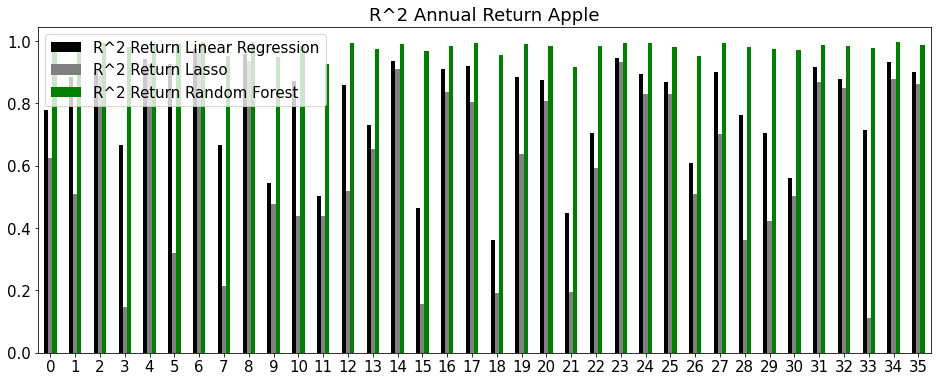

In [52]:
get_Rsquared_Annual_Return(df_aapl,"Apple", "black" , "grey" , "green");

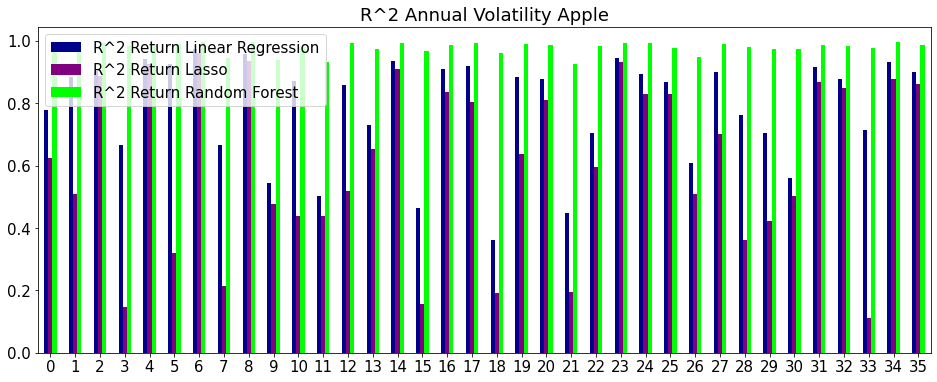

In [53]:
get_Rsquared_Annual_Volatility(df_aapl,"Apple", "darkblue" , "purple" , "lime");

### Microsoft Inc. Predictions

In [54]:
microsoft_predict = prediction(df_msft, 'Microsoft').tail(10)
microsoft_predict

Prediction Return Linear Regression  Prediction Return Lasso  \
26                             0.119033                 0.124664   
27                             0.322595                 0.332961   
28                             0.314678                 0.315354   
29                             0.473318                 0.476066   
30                             0.472646                 0.474663   
31                             0.222799                 0.224882   
32                             0.367960                 0.351708   
33                             0.203519                 0.234040   
34                             0.588001                 0.574252   
35                             0.467977                 0.466051   

    Prediction Return Random Forest  Prediction Volatility Linear Regression  \
26                         0.178260                                 0.090338   
27                         0.378659                                 0.082115   
28                         0.345478                                 0.090586   
29                         0.483140                                 0.067599   
30                         0.487270                                 0.064046   
31                         0.297285                                 0.068489   
32                         0.353323                                 0.120811   
33                         0.208969                                 0.083623   
34                         0.586200                                 0.143526   
35                         0.524118                                 0.140470   

    Prediction Volatility Lasso  Prediction Volatiliy Random Forest  
26                     0.091002                            0.092469  
27                     0.086830                            0.084894  
28                     0.091875                            0.090243  
29                     0.072675                            0.076143  
30                     0.061627                            0.063781  
31                     0.059816                            0.069914  
32                     0.131558                            0.126278  
33                     0.092573                            0.083629  
34                     0.134361                            0.141815  
35                     0.140797                            0.141784

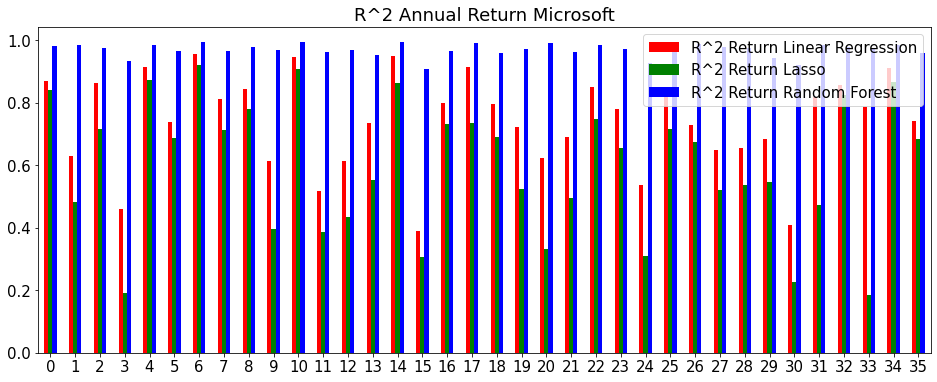

In [55]:
get_Rsquared_Annual_Return(df_msft,"Microsoft", "red" , "green" , "blue");

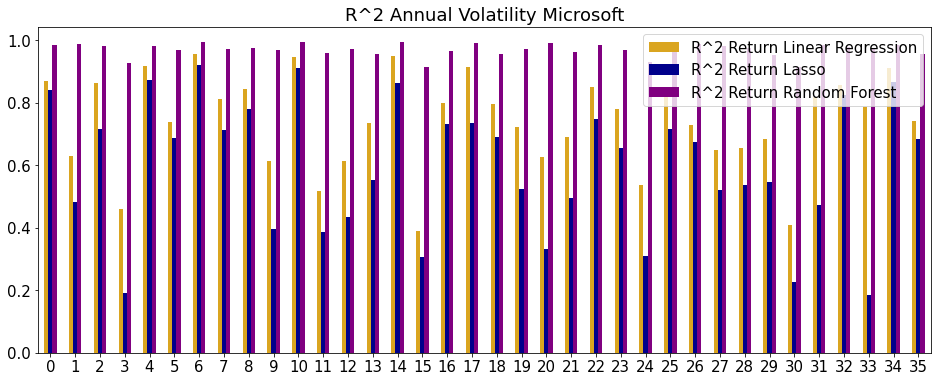

In [56]:
get_Rsquared_Annual_Volatility(df_msft,"Microsoft", "goldenrod" , 'darkblue' , "purple");

### Walmart Predictions

In [57]:
walmart_predict = prediction(df_wmt, 'Walmart').tail(10)
walmart_predict

Prediction Return Linear Regression  Prediction Return Lasso  \
26                             0.214542                 0.197887   
27                             0.221270                 0.177258   
28                             0.226870                 0.170172   
29                             0.287392                 0.312393   
30                             0.214147                 0.148203   
31                            -0.065747                 0.016031   
32                             0.239047                 0.166520   
33                             0.255288                 0.272344   
34                             0.181021                 0.168376   
35                             0.152339                 0.191750   

    Prediction Return Random Forest  Prediction Volatility Linear Regression  \
26                         0.229467                                 0.173590   
27                         0.152430                                 0.083995   
28                         0.193046                                 0.063369   
29                         0.308797                                 0.169732   
30                         0.183666                                 0.160562   
31                         0.130411                                 0.155100   
32                         0.208711                                 0.094168   
33                         0.264725                                 0.134021   
34                         0.219331                                 0.081488   
35                         0.184067                                 0.059595   

    Prediction Volatility Lasso  Prediction Volatiliy Random Forest  
26                     0.151664                            0.165633  
27                     0.099229                            0.085395  
28                     0.063047                            0.061035  
29                     0.144212                            0.169650  
30                     0.160898                            0.156812  
31                     0.151980                            0.153811  
32                     0.105895                            0.097527  
33                     0.118127                            0.125640  
34                     0.093049                            0.074549  
35                     0.057640                            0.060622

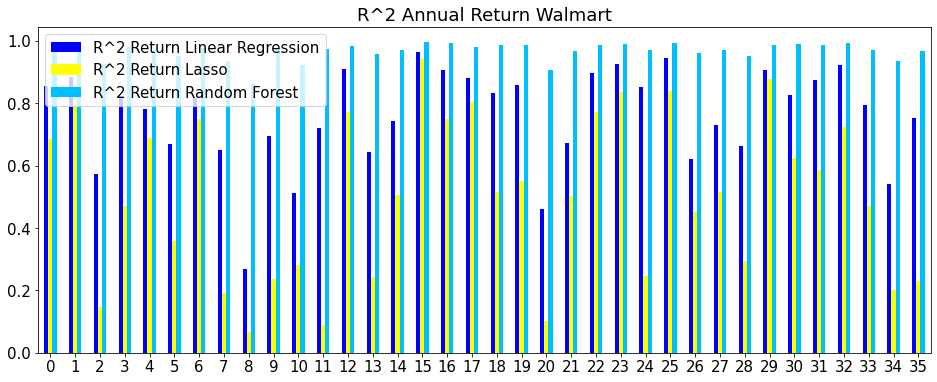

In [58]:
get_Rsquared_Annual_Return(df_wmt,"Walmart", "blue" , "yellow" , "deepskyblue");

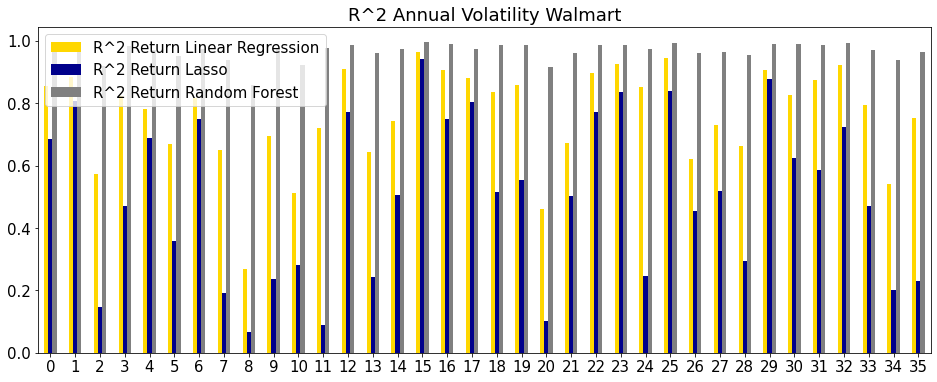

In [59]:
get_Rsquared_Annual_Volatility(df_wmt,"Walmart", "gold" , 'darkblue' , "grey");

### Amazon Predictions

In [60]:
amazon_predict = prediction(df_amzn, 'Amazon').tail(10)
amazon_predict

Prediction Return Linear Regression  Prediction Return Lasso  \
26                             0.175522                 0.251451   
27                             0.361369                 0.440506   
28                             0.270849                 0.265472   
29                             0.794781                 0.840380   
30                             0.790742                 0.758149   
31                             0.266726                 0.267720   
32                             0.312909                 0.219431   
33                            -0.139273                -0.083893   
34                             0.058706                 0.210737   
35                             0.594223                 0.554692   

    Prediction Return Random Forest  Prediction Volatility Linear Regression  \
26                         0.156856                                 0.255795   
27                         0.367316                                 0.165785   
28                         0.239264                                 0.138883   
29                         0.767727                                 0.141205   
30                         0.781571                                 0.214002   
31                         0.342905                                 0.159495   
32                         0.185976                                 0.297434   
33                        -0.116767                                 0.239050   
34                         0.197538                                 0.159544   
35                         0.567751                                 0.174929   

    Prediction Volatility Lasso  Prediction Volatiliy Random Forest  
26                     0.253971                            0.255266  
27                     0.172132                            0.170090  
28                     0.143162                            0.141183  
29                     0.139376                            0.152655  
30                     0.203828                            0.208630  
31                     0.161770                            0.176342  
32                     0.286276                            0.310772  
33                     0.275633                            0.253429  
34                     0.120908                            0.120038  
35                     0.166354                            0.170192

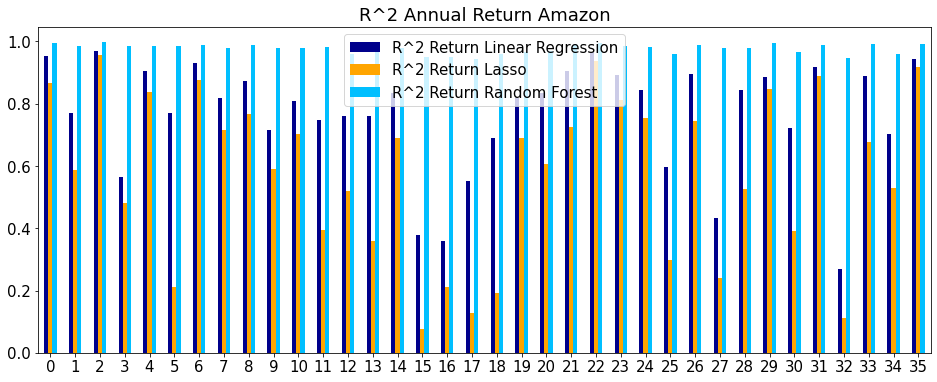

In [61]:
get_Rsquared_Annual_Return(df_amzn,"Amazon", "darkblue" , "orange" , "deepskyblue");

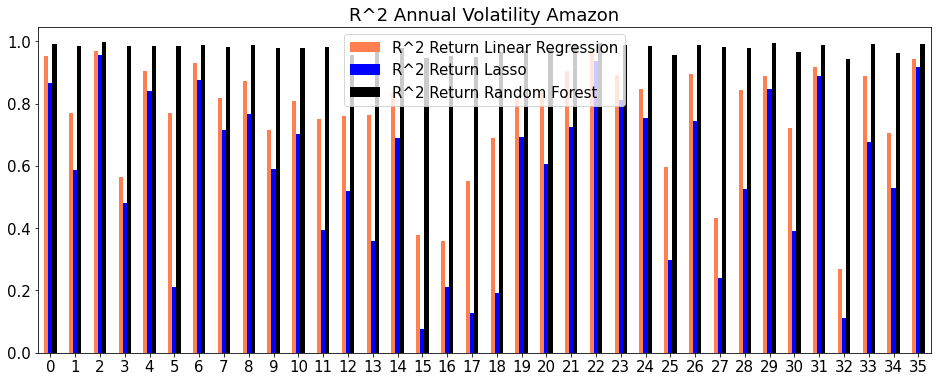

In [62]:
get_Rsquared_Annual_Volatility(df_amzn,"Amazon", "coral" , 'blue' , "black");

### Facebook Predictions

In [63]:
facebook_predict = prediction(df_fb, 'Facebook').tail(10)
facebook_predict

Prediction Return Linear Regression  Prediction Return Lasso  \
6                              0.440250                 0.368290   
7                              0.271962                 0.331669   
8                              0.391701                 0.367107   
9                              0.426280                 0.438022   
10                             0.357605                 0.381471   
11                            -0.059478                -0.122843   
12                            -0.047707                -0.056711   
13                            -0.010676                 0.021278   
14                             0.496062                 0.456221   
15                             0.047976                 0.282788   

    Prediction Return Random Forest  Prediction Volatility Linear Regression  \
6                          0.389257                                 0.074328   
7                          0.279634                                 0.092171   
8                          0.364378                                 0.088219   
9                          0.512535                                 0.084145   
10                         0.517587                                 0.096777   
11                        -0.053303                                 0.166225   
12                        -0.070031                                 0.196622   
13                        -0.000113                                 0.135826   
14                         0.426315                                 0.190898   
15                         0.133398                                 0.201946   

    Prediction Volatility Lasso  Prediction Volatiliy Random Forest  
6                      0.086694                            0.072678  
7                      0.107055                            0.107556  
8                      0.087119                            0.091648  
9                      0.088033                            0.090066  
10                     0.093061                            0.091603  
11                     0.155219                            0.171992  
12                     0.194878                            0.199100  
13                     0.159609                            0.123567  
14                     0.148549                            0.178409  
15                     0.201521                            0.200710

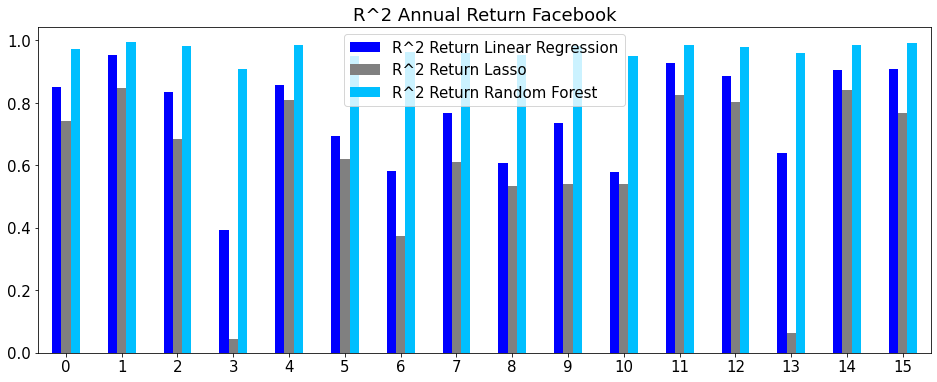

In [64]:
get_Rsquared_Annual_Return(df_fb,"Facebook", "blue" , "grey" , "deepskyblue");

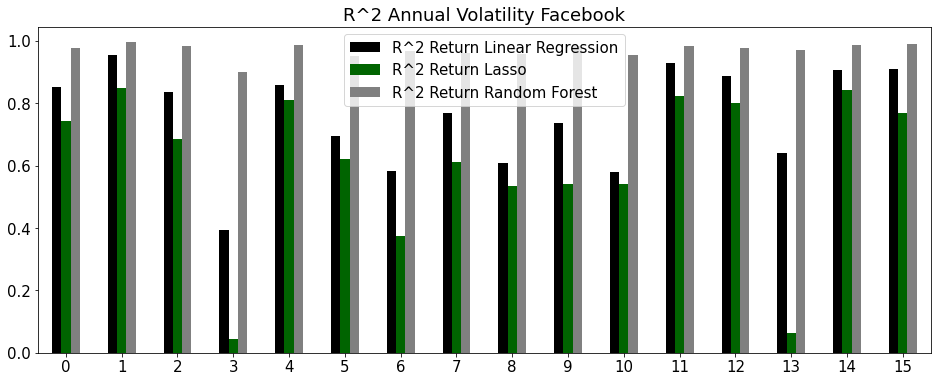

In [65]:
get_Rsquared_Annual_Volatility(df_fb,"Facebook", "black" , 'darkgreen' , "grey");

### Google Predictions

In [66]:
google_predict = prediction(df_googl, 'Google').tail(10)
google_predict

Prediction Return Linear Regression  Prediction Return Lasso  \
26                             0.097053                 0.167564   
27                             0.284880                 0.318859   
28                             0.240748                 0.259585   
29                             0.335903                 0.373425   
30                             0.222669                 0.253763   
31                            -0.061402                -0.022457   
32                             0.121211                 0.120143   
33                            -0.031925                 0.007742   
34                             0.181330                 0.284875   
35                             0.388401                 0.321245   

    Prediction Return Random Forest  Prediction Volatility Linear Regression  \
26                         0.054598                                 0.106158   
27                         0.309521                                 0.092453   
28                         0.214373                                 0.104994   
29                         0.323267                                 0.089143   
30                         0.242595                                 0.080218   
31                         0.008915                                 0.108052   
32                         0.140113                                 0.113795   
33                        -0.003670                                 0.076706   
34                         0.270168                                 0.140090   
35                         0.348251                                 0.153004   

    Prediction Volatility Lasso  Prediction Volatiliy Random Forest  
26                     0.109764                            0.116754  
27                     0.098895                            0.098255  
28                     0.103596                            0.104024  
29                     0.093092                            0.088959  
30                     0.083815                            0.080222  
31                     0.096404                            0.108488  
32                     0.117226                            0.115514  
33                     0.089063                            0.082304  
34                     0.126087                            0.137402  
35                     0.151315                            0.152302

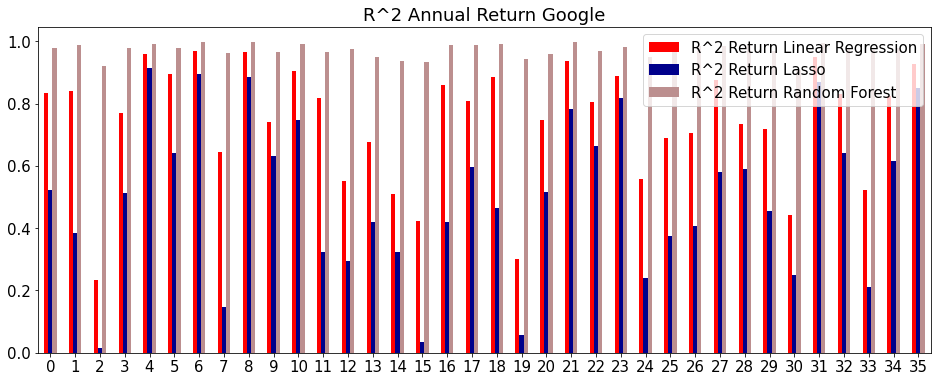

In [67]:
get_Rsquared_Annual_Return(df_googl,"Google", "red" , "darkblue" , "rosybrown");

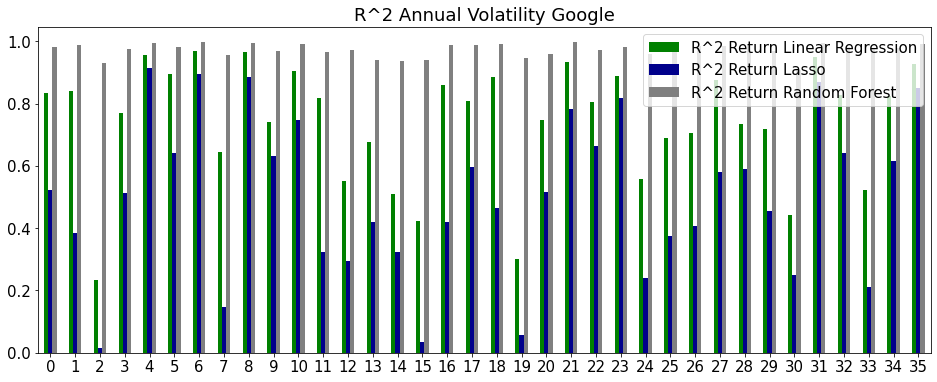

In [68]:
get_Rsquared_Annual_Volatility(df_googl,"Google", "green" , 'darkblue' , "grey");

It is clear that the random forest method produces more accurate results that both the Linear Regression and Lasso Regression. Therefore, we will use the predicted annualized returns and annualized volatility from the Random forest technique in order to construct the optimal portfolio in the following section of the project.

## Optimal Portfolio

### Start with portfolio optimization of only stocks

Take the results from the Random forest method for both the Predicted Annual Returns and Annual Volatilites of stocks

In [69]:
Predicted_Future_Annualized_Returns = [float(apple_predict.iloc[-1:, :].round(5)["Prediction Return Random Forest"].to_list()[0]),
                                       float(microsoft_predict.iloc[-1:, :].round(5)["Prediction Return Random Forest"].to_list()[0]),
                                       float(walmart_predict.iloc[-1:, :].round(5)["Prediction Return Random Forest"].to_list()[0]),
                                      float(amazon_predict.iloc[-1:, :].round(5)["Prediction Return Random Forest"].to_list()[0]),
                                      float(facebook_predict.iloc[-1:, :].round(5)["Prediction Return Random Forest"].to_list()[0]),
                                       float(google_predict.iloc[-1:, :].round(5)["Prediction Return Random Forest"].to_list()[0])]
Predicted_Future_Annualized_Returns

[0.89711, 0.52412, 0.18407, 0.56775, 0.1334, 0.34825]

In [70]:
Predicted_Future_Annualized_Volatility = [float(apple_predict.iloc[-1:, :].round(5)['Prediction Volatiliy Random Forest'].to_list()[0]),
                                       float(microsoft_predict.iloc[-1:, :].round(5)["Prediction Volatiliy Random Forest"].to_list()[0]),
                                       float(walmart_predict.iloc[-1:, :].round(5)["Prediction Volatiliy Random Forest"].to_list()[0]),
                                      float(amazon_predict.iloc[-1:, :].round(5)["Prediction Volatiliy Random Forest"].to_list()[0]),
                                      float(facebook_predict.iloc[-1:, :].round(5)["Prediction Volatiliy Random Forest"].to_list()[0]),
                                       float(google_predict.iloc[-1:, :].round(5)["Prediction Volatiliy Random Forest"].to_list()[0])]
Predicted_Future_Annualized_Volatility

[0.364, 0.14178, 0.06062, 0.17019, 0.20071, 0.1523]

Create a function that simulates 10000 portfolios with different weights that sum to one and returns the portfolio returns, portfolio volatility, portfolio Sharpe ratio and the corresponding weights to each stock.

In [71]:
def portfolio_optimization(simulations, annual_returns, annual_volatility, risk_free_rate ):
    
    weights = []
    
    for i in range(simulations):
        
        a = np.random.dirichlet(np.ones((6)),size=1).round(2)
        
        weights.append(a)
        
        ret = weights@np.array(annual_returns)
        
        vol = weights@np.array(annual_volatility)
        
        sharp = (ret - risk_free_rate) / vol
        
        portfolio_returns = [i for j  in ret.tolist() for i in j]
        
        portfolio_volatility = [i for j  in vol.tolist() for i in j]
        
        portfolio_sharpe_ratio = [i for j  in sharp.tolist() for i in j]

        
    return [portfolio_returns , portfolio_volatility , portfolio_sharpe_ratio, weights ]


Simulate the 10000 random portfolios and create 3 lists: The first one give the weights that correspond to the portfolio with the minimum annual volatility, the second to the maximum return, and the third to the maximum Sharpe ratio. 

In [72]:
random_port = portfolio_optimization(10000, Predicted_Future_Annualized_Returns, Predicted_Future_Annualized_Volatility, 0.01 )

portfolio_data = {'Portfolio Returns': random_port[0] ,
                    'Portfolio Volatility': random_port[1] ,
                    'Portfolio Sharpe Ratio': random_port[2] ,
                    'Weights': random_port[3] }

portfolio_df = pd.DataFrame(portfolio_data,
                            columns = ['Portfolio Returns','Portfolio Volatility','Portfolio Sharpe Ratio', 'Weights' ],)

min_volatility_portfolio_allocation = [i for j in 
        portfolio_df.sort_values('Portfolio Volatility').head().iloc[0]["Weights"].tolist() for i in j ]

max_annual_return_portfolio_allocation = [i for j in 
        portfolio_df.sort_values('Portfolio Returns').tail().iloc[4]["Weights"].tolist() for i in j ]

optimal_portfolio_allocation = [i for j in 
        portfolio_df.sort_values('Portfolio Sharpe Ratio').tail().iloc[4]["Weights"].tolist() for i in j ]



Print portfolios with the highest Sharpe ratios

In [73]:
portfolio_df.sort_values('Portfolio Sharpe Ratio').tail()

Portfolio Returns  Portfolio Volatility  Portfolio Sharpe Ratio  \
5263           0.446481              0.129506                3.370348   
9998           0.526412              0.152896                3.377544   
8581           0.474585              0.137077                3.389232   
2464           0.534644              0.152302                3.444752   
791            0.515228              0.146577                3.446849   

                                     Weights  
5263  [[0.01, 0.59, 0.22, 0.14, 0.01, 0.02]]  
9998   [[0.07, 0.81, 0.07, 0.04, 0.0, 0.01]]  
8581  [[0.02, 0.76, 0.16, 0.04, 0.02, 0.01]]  
2464     [[0.04, 0.83, 0.0, 0.1, 0.0, 0.02]]  
791    [[0.0, 0.66, 0.03, 0.28, 0.01, 0.01]]

Print portfolios with the highest annual returns

In [74]:
portfolio_df.sort_values('Portfolio Returns').tail()

Portfolio Returns  Portfolio Volatility  Portfolio Sharpe Ratio  \
2276           0.790389              0.317535                2.457646   
3154           0.802508              0.317349                2.497275   
912            0.805729              0.317633                2.505186   
8262           0.807622              0.334279                2.386092   
1809           0.814363              0.316120                2.544488   

                                     Weights  
2276  [[0.78, 0.05, 0.03, 0.05, 0.02, 0.08]]  
3154    [[0.79, 0.03, 0.04, 0.1, 0.0, 0.04]]  
912   [[0.78, 0.02, 0.03, 0.15, 0.01, 0.01]]  
8262   [[0.84, 0.0, 0.02, 0.06, 0.07, 0.02]]  
1809    [[0.77, 0.11, 0.0, 0.11, 0.0, 0.01]]

Print portfolios with the lowest annual volatility

In [75]:
portfolio_df.sort_values('Portfolio Volatility').head()

Portfolio Returns  Portfolio Volatility  Portfolio Sharpe Ratio  \
1865           0.217389              0.073594                2.818025   
1854           0.211246              0.082985                2.425080   
7330           0.221385              0.084408                2.504330   
9718           0.236073              0.085969                2.629696   
6340           0.283732              0.090747                3.016439   

                                     Weights  
1865    [[0.0, 0.0, 0.87, 0.09, 0.02, 0.01]]  
1854    [[0.0, 0.0, 0.81, 0.06, 0.08, 0.05]]  
7330  [[0.03, 0.03, 0.84, 0.01, 0.06, 0.03]]  
9718  [[0.01, 0.07, 0.78, 0.05, 0.06, 0.03]]  
6340   [[0.01, 0.18, 0.7, 0.08, 0.02, 0.01]]

Now let's create three pie plot that return the stock allocation depending on the preferences of the investor. (Max annual return, Min annual volatility, Optimal Allocation) There are some investors who want to minimize volatility and others who want to maximize returns. However, the overwhelming majority of investors wants to allocate their assets in order to maximize Sharpe ratio (Excess annual return / Annual Volatility). 

In [77]:
stocks = ['Apple','Microsoft','Walmart', 'Amazon', 'Facebook', 'Google']


fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]],
                   subplot_titles=("Maximum Annual Return Portfolio Allocation", 
                                   "Minimum Annual Volatility Portfolio Allocation", "Optimal Portfolio Allocation"))
fig.add_trace(go.Pie(labels=stocks, values= max_annual_return_portfolio_allocation, 
                     name="Maximum Annual Return Portfolio Allocation"), 1, 1)
fig.add_trace(go.Pie(labels=stocks, values= min_volatility_portfolio_allocation, 
                     name="Minimum Annual Volatility Portfolio Allocation"), 1, 2)
fig.add_trace(go.Pie(labels=stocks, values= optimal_portfolio_allocation, 
                     name="Optimal Portfolio Allocation"), 2, 1)

fig.update_layout(autosize=False, width=1000,height=800)


fig.show()


### Incorporate Bonds and Stocks in the optimal portfolio allocation

Since bond ETFs are less risky than stocks, we do not need to predict tomorrow's annual return and annual volatility. Hence, we will take the historical annual return and historical annual volatility given by the data frame. Then, we will replicate the portfolio simulation that we did for stocks and keep only the portfolio whose weights result in the maximum Sharpe ratio. Finally, depending on the risk aversion of the investor, we will change the percentages of the portfolios that will go towards stocks, and bond ETFs.

In [78]:
historical_annual_returns_bond_ETF = annualized_returns_bonds.iloc[-1].tolist()
historical_annual_volatility_bond_ETF = annualized_volatility_bonds.iloc[-1].tolist()

In [79]:
def portfolio_optimization_bonds(simulations, annual_returns, annual_volatility, risk_free_rate ):
    
    weights = []
    
    for i in range(simulations):
        
        a = np.random.dirichlet(np.ones((4)),size=1).round(2)
        
        weights.append(a)
        
        ret = weights@np.array(annual_returns)
        
        vol = weights@np.array(annual_volatility)
        
        sharp = (ret - risk_free_rate) / vol
        
        portfolio_returns = [i for j  in ret.tolist() for i in j]
        
        portfolio_volatility = [i for j  in vol.tolist() for i in j]
        
        portfolio_sharpe_ratio = [i for j  in sharp.tolist() for i in j]

        
    return [portfolio_returns , portfolio_volatility , portfolio_sharpe_ratio, weights ]


In [80]:
random_port_bond_ETF = portfolio_optimization_bonds(10000, historical_annual_returns_bond_ETF, 
                                              historical_annual_volatility_bond_ETF, 0.01 )

port_data_bonds = {'Portfolio Returns': random_port_bond_ETF[0] ,
                    'Portfolio Volatility': random_port_bond_ETF[1] ,
                    'Portfolio Sharpe Ratio': random_port_bond_ETF[2] ,
                    'Weights': random_port_bond_ETF[3] }

portfolio_df_bonds = pd.DataFrame(port_data_bonds,
                            columns = ['Portfolio Returns','Portfolio Volatility','Portfolio Sharpe Ratio', 'Weights' ],)

min_volatility_portfolio_allocation_bonds = [i for j in 
        portfolio_df_bonds.sort_values('Portfolio Volatility').head().iloc[0]["Weights"].tolist() for i in j ]

max_annual_return_portfolio_allocation_bonds = [i for j in 
        portfolio_df_bonds.sort_values('Portfolio Returns').tail().iloc[4]["Weights"].tolist() for i in j ]

optimal_portfolio_allocation_bonds = [i for j in 
        portfolio_df_bonds.sort_values('Portfolio Sharpe Ratio').tail().iloc[4]["Weights"].tolist() for i in j ]



In [81]:
Dynamic_Growth_Portfolio = ([i * 0.8 for i in optimal_portfolio_allocation] + 
                     [j * 0.2 for j in optimal_portfolio_allocation_bonds])
Balanced_Growth_Portfolio = ([i * 0.6 for i in optimal_portfolio_allocation] + 
                     [j * 0.4 for j in optimal_portfolio_allocation_bonds])
Balanced_Portfolio = ([i * 0.5 for i in optimal_portfolio_allocation] + 
                     [j * 0.5 for j in optimal_portfolio_allocation_bonds])
Conservative_Portfolio = ([i * 0.4 for i in optimal_portfolio_allocation] + 
                     [j * 0.6 for j in optimal_portfolio_allocation_bonds])
Defensive_Portfolio = ([i * 0.2 for i in optimal_portfolio_allocation] + 
                     [j * 0.8 for j in optimal_portfolio_allocation_bonds])

In [82]:
stocks = ['Apple','Microsoft','Walmart', 'Amazon', 'Facebook', 'Google']

bond_ETFS = ["BND" , "VCIT" , "VCSH" , "VBTLX" , "AGG"]

stocks_and_bonds = ['Apple','Microsoft','Walmart', 'Amazon', 'Facebook', 'Google',
                    "BND" , "VCIT" , "VCSH" , "VBTLX" , "AGG"]

fig = make_subplots( rows=3, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}],
                    [{'type':'domain'}, {'type':'domain'}]] ,
                   subplot_titles=("All Equity Portfolio", "Dynamic Growth Portfolio (80% stocks 20% bond ETF)", 
                "Balanced Growth Portfolio (60% stocks 40% bond ETF)" , "Balanced Portfolio (50% stocks 50% bond ETF)",
                "Conservative Portfolio (40% stocks 60% bond ETF)", "Defensive Portfolio (20% stocks 80% bond ETF)"))
fig.add_trace(go.Pie(labels=stocks, values= optimal_portfolio_allocation, 
                     name="All Equity Portfolio"), 1, 1)
fig.add_trace(go.Pie(labels=stocks_and_bonds, values= Dynamic_Growth_Portfolio, 
                     name="Dynamic Growth Portfolio"), 1, 2)
fig.add_trace(go.Pie(labels=stocks_and_bonds, values= Balanced_Growth_Portfolio, 
                     name="Balanced Growth Portfolio"), 2, 1)
fig.add_trace(go.Pie(labels=stocks_and_bonds, values= Balanced_Portfolio, 
                     name="Balanced Portfolio"), 2, 2)
fig.add_trace(go.Pie(labels=stocks_and_bonds, values= Conservative_Portfolio, 
                     name="Conservative Portfolio"), 3, 1)
fig.add_trace(go.Pie(labels=stocks_and_bonds, values= Defensive_Portfolio, 
                     name="Defensive Portfolio"), 3, 2)


fig.update_layout(autosize=False, width=1000,height=1300)


fig.show()


### Potential Problems:

One potential problem of the model is that since we do not have access to proprietary data, we do not have the real daily changes of the fundamental indicators. Instead, we created daily approximations for the values in between quarters to make a data frame that updates on a daily basis. 

Another problem, which also arises from the fact that we use only free data, is that it takes a lot of time to collect the data from the various sources. Hence, it very time consuming to load and create the final format of the data frames.

### Further Improvements

Expand the model to predict further into the future; not only tomorrow's annual return and annual volatility.

Incorporate other assets such as commodities, mutual funds, cryptocurrencies, REITS in order to achieve greater diversification of the optimal portfolio.